In [1]:
# ==========================================
# CELL 1: Import all required libraries
# ==========================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    auc
)

from sklearn.ensemble import RandomForestClassifier
import joblib

# Install and import SMOTE for oversampling
!pip install imbalanced-learn
from imblearn.over_sampling import SMOTE


In [2]:
# ==========================================
# CELL 2: Load the CSV dataset
# ==========================================

file = "iotsim-combined-cycle-10.csv"

# Load CSV safely ignoring corrupted lines
df = pd.read_csv(file, on_bad_lines="skip", low_memory=False)

print("Dataset loaded successfully!")
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
print("\nOriginal class distribution:")
print(df["label"].value_counts())


Dataset loaded successfully!
Shape: (138509, 23)
Columns: ['frame.time', 'frame.len', 'frame.protocols', 'eth.src', 'eth.dst', 'ip.dst', 'ip.src', 'ip.flags', 'ip.ttl', 'ip.proto', 'ip.checksum', 'ip.tos', 'tcp.srcport', 'tcp.dstport', 'tcp.flags', 'tcp.window_size_value', 'tcp.window_size_scalefactor', 'tcp.checksum', 'tcp.options', 'tcp.pdu.size', 'udp.srcport', 'udp.dstport', 'label']

Original class distribution:
label
TCP Scan                 106000
Telnet Brute Force        26122
Ingress Tool Transfer      3206
File Download              1210
Benign                      974
Unknown                     843
C&C Communication            90
Reporting                    64
Name: count, dtype: int64


In [3]:
# ==========================================
# CELL 3: Convert all attack types into a single 'Malicious' class
# ==========================================

df["label"] = df["label"].apply(lambda x: "Benign" if x == "Benign" else "Malicious")

print("Labels simplified successfully.")
print(df["label"].value_counts())


Labels simplified successfully.
label
Malicious    137535
Benign          974
Name: count, dtype: int64


In [4]:
# ==========================================
# CELL 4: Remove irrelevant columns and clean dataset
# ==========================================

# Columns that are not useful for prediction
cols_to_drop = [
    "eth.src", "eth.dst", "ip.src", "ip.dst",
    "tcp.flags", "tcp.checksum",
    "frame.time", "tcp.options", "frame.protocols"
]

# Drop columns if they exist in the dataset
df = df.drop([c for c in cols_to_drop if c in df.columns], axis=1, errors="ignore")

# Attempt to convert remaining columns to numeric
df = df.apply(pd.to_numeric, errors="ignore")

# Drop rows with more than 50% missing values
df = df.dropna(thresh=len(df.columns) * 0.5)

print("Shape after cleaning:", df.shape)
print("Missing values per column:")
print(df.isnull().sum())


Shape after cleaning: (138509, 14)
Missing values per column:
frame.len                           0
ip.flags                            0
ip.ttl                              0
ip.proto                            0
ip.checksum                         0
ip.tos                         138509
tcp.srcport                       974
tcp.dstport                       974
tcp.window_size_value             974
tcp.window_size_scalefactor     64867
tcp.pdu.size                   138509
udp.srcport                    137535
udp.dstport                    137535
label                               0
dtype: int64


/tmp/ipython-input-2875509521.py:16: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors="ignore")


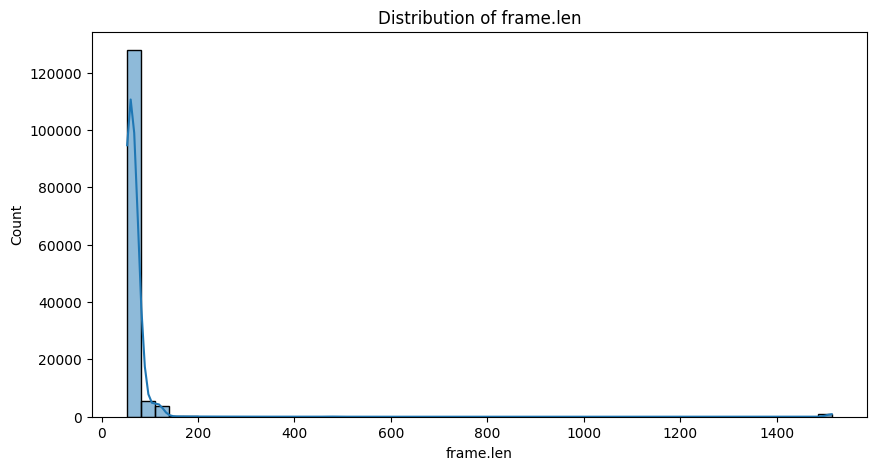

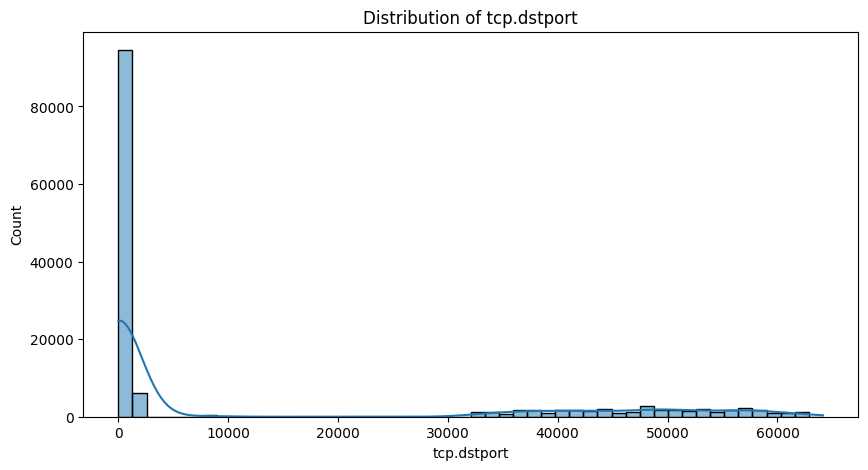

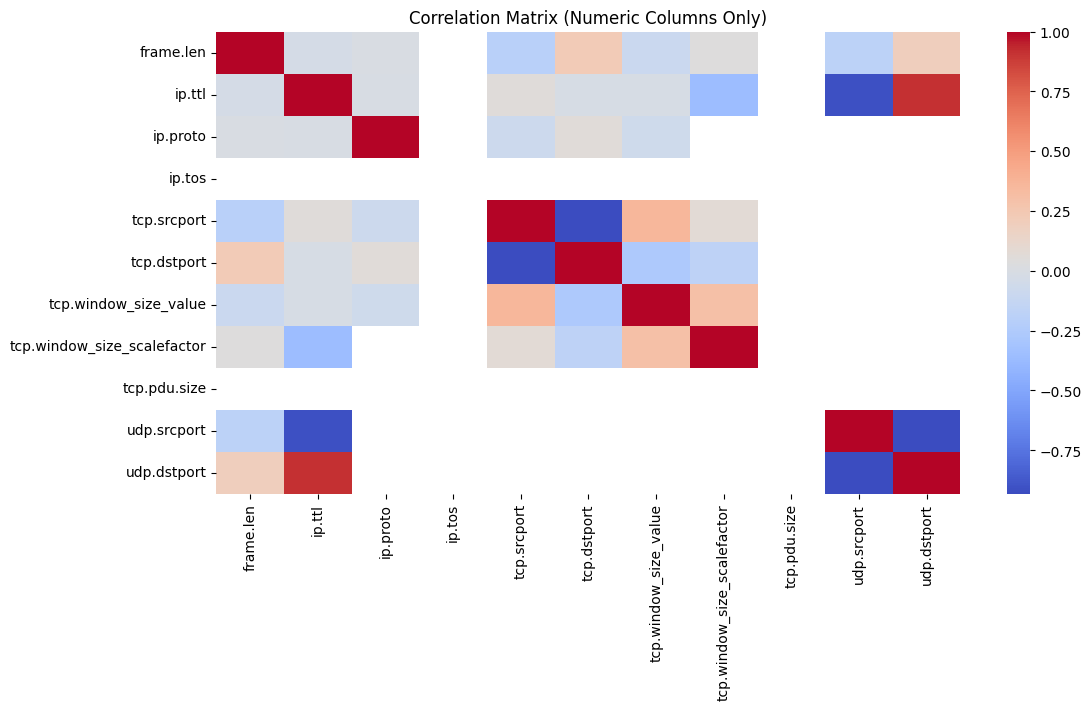

In [5]:
# CELL 5: Basic EDA - Understanding data distribution

# Packet length distribution
plt.figure(figsize=(10,5))
sns.histplot(df["frame.len"], bins=50, kde=True)
plt.title("Distribution of frame.len")
plt.show()

# TCP destination port distribution
plt.figure(figsize=(10,5))
sns.histplot(df["tcp.dstport"], bins=50, kde=True)
plt.title("Distribution of tcp.dstport")
plt.show()

# Correlation matrix (numeric columns only)
numeric_df = df.select_dtypes(include=[np.number])

plt.figure(figsize=(12,6))
sns.heatmap(numeric_df.corr(), cmap="coolwarm")
plt.title("Correlation Matrix (Numeric Columns Only)")
plt.show()


In [6]:
# CELL 6 — Prepare predictor variables (X) and target (y)

# Encode labels
le = LabelEncoder()
df["label_encoded"] = le.fit_transform(df["label"])

# Keep only numeric columns
numeric_df = df.select_dtypes(include=[np.number])

# Impute missing values with median (SMOTE requires zero NaN)
numeric_df = numeric_df.fillna(numeric_df.median())

# Define X and y
X = numeric_df.drop(["label_encoded"], axis=1)
y = df["label_encoded"]

print("Numeric columns used in X:", X.columns.tolist())
print("\nX shape:", X.shape)
print("\nMissing values in X (should be 0):")
print(X.isnull().sum().sum())
print("\ny distribution:")
print(y.value_counts())



Numeric columns used in X: ['frame.len', 'ip.ttl', 'ip.proto', 'ip.tos', 'tcp.srcport', 'tcp.dstport', 'tcp.window_size_value', 'tcp.window_size_scalefactor', 'tcp.pdu.size', 'udp.srcport', 'udp.dstport']

X shape: (138509, 11)

Missing values in X (should be 0):
277018

y distribution:
label_encoded
1    137535
0       974
Name: count, dtype: int64


In [9]:
# CELL 7 — Split dataset, impute missing values, and apply scaling

from sklearn.impute import SimpleImputer

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# Impute missing values AFTER splitting
imputer = SimpleImputer(strategy="median")

X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

print("Training set shape:", X_train_scaled.shape)
print("Testing set shape:", X_test_scaled.shape)

# Check for NaN (should be 0)
print("NaN in X_train_scaled:", np.isnan(X_train_scaled).sum())
print("NaN in X_test_scaled:", np.isnan(X_test_scaled).sum())



Training set shape: (96956, 9)
Testing set shape: (41553, 9)
NaN in X_train_scaled: 0
NaN in X_test_scaled: 0


/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['ip.tos' 'tcp.pdu.size']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['ip.tos' 'tcp.pdu.size']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


In [10]:
# ==========================================
# CELL 8: Apply SMOTE to oversample the minority class
# ==========================================

smote = SMOTE(random_state=42, k_neighbors=5)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

print("Before SMOTE:")
print(y_train.value_counts())

print("\nAfter SMOTE:")
print(pd.Series(y_train_resampled).value_counts())


Before SMOTE:
label_encoded
1    96274
0      682
Name: count, dtype: int64

After SMOTE:
label_encoded
1    96274
0    96274
Name: count, dtype: int64


In [11]:
# ==========================================
# CELL 9: Train Random Forest using balanced data
# ==========================================

model = RandomForestClassifier(
    n_estimators=150,
    max_depth=16,
    n_jobs=-1,
    random_state=42
)

model.fit(X_train_resampled, y_train_resampled)

print("Model trained successfully!")


Model trained successfully!


In [12]:
# ==========================================
# CELL 10: Evaluate performance on test data
# ==========================================

y_pred = model.predict(X_test_scaled)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1-score:", f1_score(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-score: 1.0

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       292
           1       1.00      1.00      1.00     41261

    accuracy                           1.00     41553
   macro avg       1.00      1.00      1.00     41553
weighted avg       1.00      1.00      1.00     41553



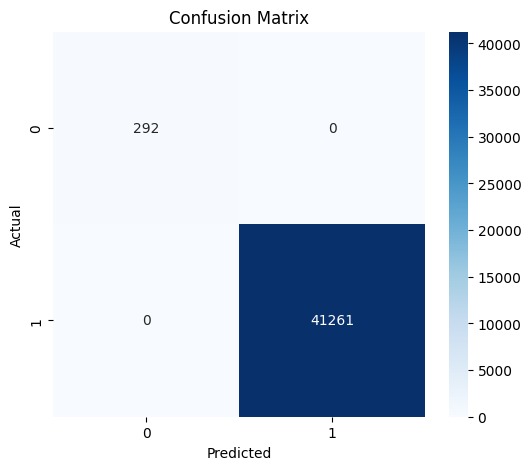

In [13]:
# ==========================================
# CELL 11: Display Confusion Matrix
# ==========================================

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


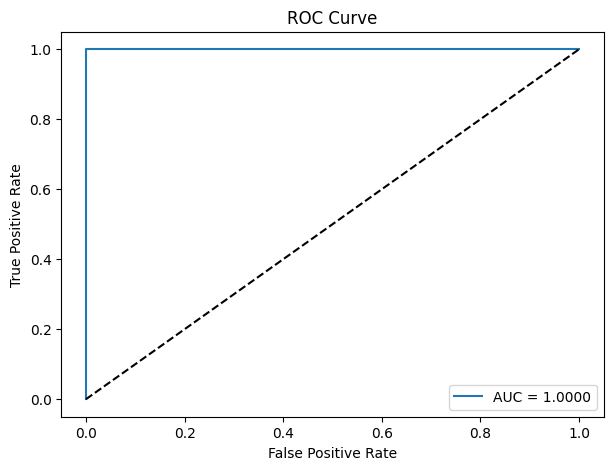

In [14]:
# ==========================================
# CELL 12: Plot ROC Curve and compute AUC
# ==========================================

y_prob = model.predict_proba(X_test_scaled)[:,1]

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0,1], [0,1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


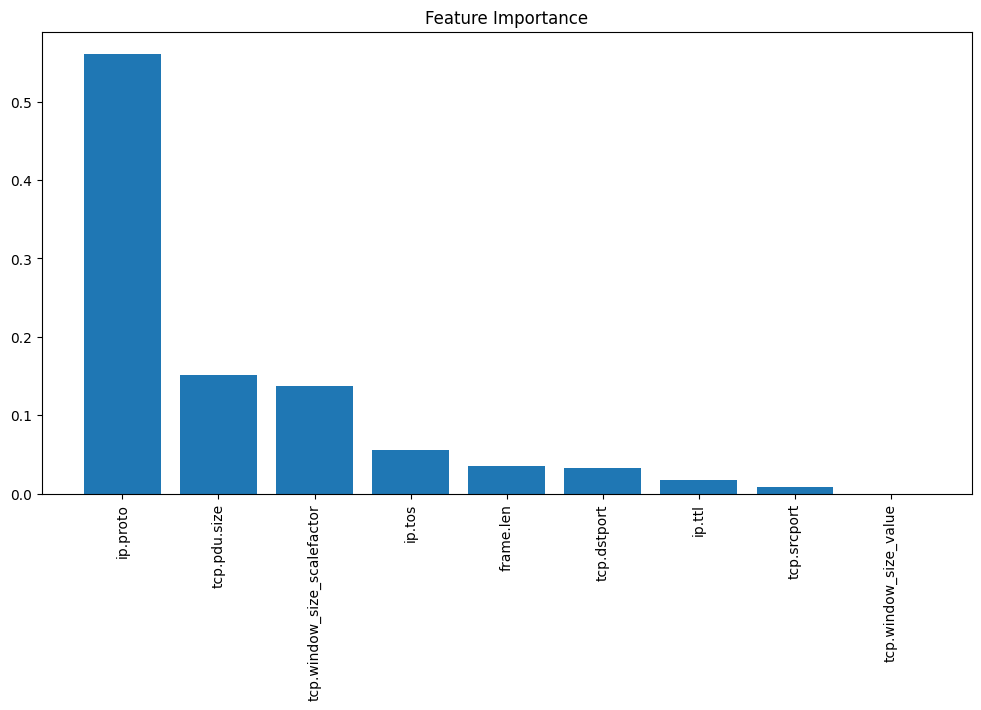

In [15]:
# ==========================================
# CELL 13: Feature Importance
# ==========================================

importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12,6))
plt.bar(range(len(indices)), importances[indices])
plt.xticks(range(len(indices)), X.columns[indices], rotation=90)
plt.title("Feature Importance")
plt.show()


In [16]:
# ==========================================
# CELL 14: Save model and scaler for future use
# ==========================================

joblib.dump(model, "IDS_CombinedCycle_Model_SMOTE.pkl")
joblib.dump(scaler, "IDS_CombinedCycle_Scaler.pkl")

print("Files saved successfully!")


Files saved successfully!
